# Preprocess the dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import seaborn as sb
import pingouin as pg
import random
import os
from statsmodels.formula.api import ols
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 6),
         'axes.labelsize': 20,
         'axes.titlesize':16,
         'axes.labelcolor':"#000000",
         'xtick.labelsize':20,
         'ytick.labelsize':16,
         'font.weight':"normal",
         'xtick.color':"#000000",
         'ytick.color':"#000000",
         'axes.labelweight':'normal'}
pylab.rcParams.update(params)
%matplotlib inline

data_src = './cloud_results/'
save_dir = f'./statistics/new/'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

In [2]:
def Variable2Vitual(df, attribute, values=None):
    # convert a multi-value attribute column to multiple virtual variables
    if values is None:
        values = set(df[attribute])
    for v in values:
        df[f'is_{v}'] = (df[attribute]==v).astype(int)
    return df

def read_cloud(csv_path, cloud_name):
    # preprocess the csv data
    data = pd.read_csv(csv_path)
    data['Attack'] = data['Attack'].str.upper()
    data['Attack'][data['Attack'] == 'BL-BFGS'] = 'BLB'
    data['is_Pretrained'] = data['Pretrained'].astype(int)
    data['local_success_rate'] = data['total']/200
    data['cloud'] = cloud_name
    return data

def export_ols(ols_result, filename):
    with open(filename, 'w') as f:
        f.write(ols_result.summary().as_csv())

dataset = 'AdienceGenderG'
df_list = []
for cloud in ['aliyun', 'baidu', 'aws']:
    csv_path = data_src+f'{cloud}_{dataset}.csv'
    df = read_cloud(csv_path, cloud)
    df_list.append(df)
data = pd.concat(df_list, axis=0)
data.head()

,Architecture,Data_type,Depth,Pretrained,Attack,misclassification_rate,female2male_rate,male2female_rate,total,nr_female,nr_male,mis_ratio,female2male_rate_100,male2female_rate_100,is_Pretrained,local_success_rate,cloud
0,inception,raw,V3,True,BLB,0.050000,0.050000,0.050000,200,100,100,0.050,0.05,0.05,1,1.000,aliyun
1,inception,raw,V3,True,CW2,0.050251,0.050000,0.050505,199,100,99,0.050,0.05,0.05,1,0.995,aliyun
2,inception,raw,V3,True,DEEPFOOL,0.040698,0.023529,0.057471,172,85,87,0.035,0.02,0.05,1,0.860,aliyun
3,inception,raw,V3,True,FGSM,0.102151,0.118280,0.086022,186,93,93,0.095,0.11,0.08,1,0.930,aliyun
4,inception,raw,V3,True,LLC,0.056604,0.076923,0.037037,106,52,54,0.030,0.04,0.02,1,0.530,aliyun


In [3]:
# reformalize data
for attr in ['Architecture', 'Data_type', 'Attack', 'cloud']:
    data = Variable2Vitual(data, attr)
data = Variable2Vitual(data, 'Depth', ['18', '34', '50'])
# remove unnecessary columns
df = data.drop(['Architecture', 'Data_type', 'Attack', 'Depth', 'total', 'Pretrained', 'mis_ratio', 'cloud', 'local_success_rate', 'misclassification_rate'], axis=1)
res_df = df[df['is_resnet']==1].copy(deep=True).reset_index(drop=True)
df.head()

,female2male_rate,male2female_rate,nr_female,nr_male,female2male_rate_100,male2female_rate_100,is_Pretrained,is_vgg,is_inception,is_resnet,...,is_UAP,is_STEP_LLC,is_RFGSM,is_LLC,is_aws,is_aliyun,is_baidu,is_18,is_34,is_50
0,0.050000,0.050000,100,100,0.05,0.05,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.050000,0.050505,100,99,0.05,0.05,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,0.023529,0.057471,85,87,0.02,0.05,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0.118280,0.086022,93,93,0.11,0.08,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0.076923,0.037037,52,54,0.04,0.02,1,0,1,0,...,0,0,0,1,0,1,0,0,0,0


In [4]:
# visualize all the columns
df.columns

Index(['female2male_rate', 'male2female_rate', 'nr_female', 'nr_male',
       'female2male_rate_100', 'male2female_rate_100', 'is_Pretrained',
       'is_vgg', 'is_inception', 'is_resnet', 'is_augmented', 'is_raw',
       'is_adversarial', 'is_FGSM', 'is_DEEPFOOL', 'is_BLB', 'is_CW2',
       'is_PGD', 'is_UAP', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_aws',
       'is_aliyun', 'is_baidu', 'is_18', 'is_34', 'is_50'],
      dtype='object')

# The large OLS table and statistical tests

In [5]:
# Two methods for comparing coefficients. We use Wald's R test 

# def Generate_Compare_Formula(original_formula, compare_v1, compare_v2):
#     # helper func for generating formula for compare two factors
#     # It removes v1 and v2 from the formula, but adds v1+v2 and v1-v2.
#     # Assume the regression coefficient of v1+v2 is x and the coefficient of v1-v2 is y.
#     # If y>0 significantly, then the regression model x(v1+v2)+y(v1-v2) = (x+y)v1 + (x-y)v2, and thus the coefficient of v2 is less than v1 since x-y < x+y. The p-value of the test y<=0 is thus a valid p-value for the latter.
#     original_formula = original_formula + f'-{compare_v1}-{compare_v2}'
#     original_formula += f'+I({compare_v1}+{compare_v2})+I({compare_v2}-{compare_v1})'
#     return original_formula

def Test_Wald_R(ols_result, R_coef:list, R_var_name:list, return_result=False):
    # Test H0: R * coef = 0.
    # e.g. For R_coef = [1,-1], coef = [is_aliyun, is_baidu], this tests H0: is_aliyun - is_baidu = 0, which is equivalent to test H0: is_aliyun = is_baidu.
    # this is used to compare the coefficients of variables.
    assert len(R_coef) == len(R_var_name), 'One to one map should be given.'
    params = ols_result.params
    idx_map = dict([(list(params.index)[i], i) for i in range(len(list(params.index)))])
    R = np.zeros(len(params))
    for r, var in zip(R_coef, R_var_name):
        R[idx_map[var]] = r
    test = ols_result.wald_test(R)
    print(test.summary())
    if return_result:
        return test

## Regression A

dependent variable: female2male rate

explain variables: platform

In [6]:
# total_exp = ['is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# baseline setting: raw + UAP + 18
exp_vs = ['is_aws', 'is_baidu', 'is_aliyun']

dp_variable = 'female2male_rate'

formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs)) # exclude the intercept
# formula = Generate_Compare_Formula(formula, 'is_FGSM', 'is_DEEPFOOL')

# add cross terms to formula
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_augmented',]])
# formula += '+' + '+'.join([f'I({attr1}*{attr2})' for attr1 in ['is_Pretrained', 'is_adversarial', 'is_augmented', ] for attr2 in ['is_34', 'is_50']])
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])

print(formula)
model = ols(formula, data=res_df)
results = model.fit()
# export_ols(results, './ols_result/imagenet/joint_ols_match.csv')
results.summary()

female2male_rate ~ 0+is_aws+is_baidu+is_aliyun


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       female2male_rate   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     42.77
Date:                Tue, 15 Mar 2022   Prob (F-statistic):           7.90e-18
Time:                        21:09:14   Log-Likelihood:                 723.62
No. Observations:                 486   AIC:                            -1441.
Df Residuals:                     483   BIC:                            -1429.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
is_aws         0.0278      0.004      6.461      0.000       0.019       0.036
is_baidu       0.0687      0.004     15.957      0.000       0.060       0.077
is_aliyun      0.0817      0.004     19.000      0.000       0.073       0.090
==============================================================================
Omnibus:                      184.958   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              622.320
Skew:                           1.782   Prob(JB):                    7.33e-136
Kurtosis:                       7.246   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
# Test: AWS < Baidu < Aliyun

Test_Wald_R(results, [1,-1], ['is_aws', 'is_baidu'])
Test_Wald_R(results, [1,-1], ['is_baidu', 'is_aliyun'])

<F test: F=array([[45.08108669]]), p=5.321236765348104e-11, df_denom=483, df_num=1>
<F test: F=array([[4.6303017]]), p=0.03190705108481524, df_denom=483, df_num=1>


## Regression B

dependent variable: female2male rate

explain variables: platform + pretraining + dataset

In [8]:
# total_exp = ['is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# baseline setting: raw + UAP + 18
exp_vs = ['is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented']

dp_variable = 'female2male_rate'

formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs)) # exclude the intercept
# formula = Generate_Compare_Formula(formula, 'is_FGSM', 'is_DEEPFOOL')

# add cross terms to formula
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_augmented',]])
# formula += '+' + '+'.join([f'I({attr1}*{attr2})' for attr1 in ['is_Pretrained', 'is_adversarial', 'is_augmented', ] for attr2 in ['is_34', 'is_50']])
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])

print(formula)
model = ols(formula, data=res_df)
results = model.fit()
# export_ols(results, './ols_result/imagenet/joint_ols_match.csv')
results.summary()

female2male_rate ~ 0+is_aws+is_baidu+is_aliyun+is_Pretrained+is_adversarial+is_augmented


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       female2male_rate   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     26.76
Date:                Tue, 15 Mar 2022   Prob (F-statistic):           6.96e-24
Time:                        21:09:14   Log-Likelihood:                 743.74
No. Observations:                 486   AIC:                            -1475.
Df Residuals:                     480   BIC:                            -1450.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
is_aws             0.0231      0.006      3.953      0.000       0.012       0.035
is_baidu           0.0640      0.006     10.929      0.000       0.052       0.076
is_aliyun          0.0771      0.006     13.165      0.000       0.066       0.089
is_Pretrained      0.0186      0.005      3.896      0.000       0.009       0.028
is_adversarial    -0.0214      0.006     -3.661      0.000      -0.033      -0.010
is_augmented       0.0075      0.006      1.273      0.204      -0.004       0.019
==============================================================================
Omnibus:                      150.661   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              430.709
Skew:                           1.491   Prob(JB):                     2.97e-94
Kurtosis:                       6.518   Cond. No.                         4.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression C

dependent variable: female2male rate

explain variables: platform + pretraining + dataset + adversarial algorithm

In [39]:
# total_exp = ['is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# baseline setting: raw + UAP + 18
exp_vs = ['is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC']

dp_variable = 'female2male_rate'

formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs)) # exclude the intercept
# formula = Generate_Compare_Formula(formula, 'is_FGSM', 'is_DEEPFOOL')

# add cross terms to formula
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_augmented',]])
# formula += '+' + '+'.join([f'I({attr1}*{attr2})' for attr1 in ['is_Pretrained', 'is_adversarial', 'is_augmented', ] for attr2 in ['is_34', 'is_50']])
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])

print(formula)
model = ols(formula, data=res_df)
results = model.fit()
# export_ols(results, './ols_result/imagenet/joint_ols_match.csv')
results.summary()

female2male_rate ~ 0+is_aws+is_baidu+is_aliyun+is_Pretrained+is_adversarial+is_augmented+is_PGD+is_FGSM+is_BLB+is_CW2+is_DEEPFOOL+is_STEP_LLC+is_RFGSM+is_LLC


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       female2male_rate   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     45.82
Date:                Fri, 18 Mar 2022   Prob (F-statistic):           3.79e-75
Time:                        14:40:11   Log-Likelihood:                 882.35
No. Observations:                 486   AIC:                            -1737.
Df Residuals:                     472   BIC:                            -1678.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
is_aws            -0.0075      0.007     -1.102      0.271      -0.021       0.006
is_baidu           0.0334      0.007      4.921      0.000       0.020       0.047
is_aliyun          0.0465      0.007      6.851      0.000       0.033       0.060
is_Pretrained      0.0186      0.004      5.138      0.000       0.012       0.026
is_adversarial    -0.0214      0.004     -4.829      0.000      -0.030      -0.013
is_augmented       0.0075      0.004      1.679      0.094      -0.001       0.016
is_PGD             0.0559      0.008      7.272      0.000       0.041       0.071
is_FGSM            0.0924      0.008     12.012      0.000       0.077       0.107
is_BLB            -0.0002      0.008     -0.031      0.976      -0.015       0.015
is_CW2             0.0011      0.008      0.140      0.889      -0.014       0.016
is_DEEPFOOL       -0.0126      0.008     -1.636      0.103      -0.028       0.003
is_STEP_LLC        0.0703      0.008      9.142      0.000       0.055       0.085
is_RFGSM           0.0393      0.008      5.105      0.000       0.024       0.054
is_LLC             0.0295      0.008      3.835      0.000       0.014       0.045
==============================================================================
Omnibus:                      141.171   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              496.892
Skew:                           1.305   Prob(JB):                    1.26e-108
Kurtosis:                       7.211   Cond. No.                         10.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
# Test: DeepFool \approx BLB \approx UAP 
# Test: UAP \approx CW2 < LLC \approx RFGSM < PGD < Step-LLC < FGSM
Test_Wald_R(results, [1,-1], ['is_DEEPFOOL', 'is_BLB'])
Test_Wald_R(results, [1,-1], ['is_DEEPFOOL', 'is_CW2'])
Test_Wald_R(results, [1,-1], ['is_CW2', 'is_LLC'])
Test_Wald_R(results, [1,-1], ['is_LLC', 'is_RFGSM'])
Test_Wald_R(results, [1,-1], ['is_RFGSM', 'is_PGD'])
Test_Wald_R(results, [1,-1], ['is_PGD', 'is_STEP_LLC'])
Test_Wald_R(results, [1,-1], ['is_STEP_LLC', 'is_FGSM'])



<F test: F=array([[2.5760685]]), p=0.10915965516675383, df_denom=472, df_num=1>
<F test: F=array([[3.15124947]]), p=0.07651320054607465, df_denom=472, df_num=1>
<F test: F=array([[13.65693753]]), p=0.0002451536224109335, df_denom=472, df_num=1>
<F test: F=array([[1.61265348]]), p=0.20474490001854248, df_denom=472, df_num=1>
<F test: F=array([[4.69458725]]), p=0.03075739606531983, df_denom=472, df_num=1>
<F test: F=array([[3.49634725]]), p=0.0621231732578, df_denom=472, df_num=1>
<F test: F=array([[8.23722151]]), p=0.004288258131355551, df_denom=472, df_num=1>


## Regression D

dependent variable: female2male rate

explain variables: platform + pretraining + dataset + adversarial algorithm + surrogate depth

In [11]:
# total_exp = ['is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# baseline setting: raw + UAP + 18
exp_vs = ['is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

dp_variable = 'female2male_rate'

formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs)) # exclude the intercept
# formula = Generate_Compare_Formula(formula, 'is_FGSM', 'is_DEEPFOOL')

# add cross terms to formula
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_augmented',]])
# formula += '+' + '+'.join([f'I({attr1}*{attr2})' for attr1 in ['is_Pretrained', 'is_adversarial', 'is_augmented', ] for attr2 in ['is_34', 'is_50']])
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])

print(formula)
model = ols(formula, data=res_df)
results = model.fit()
# export_ols(results, './ols_result/imagenet/joint_ols_match.csv')
results.summary()

female2male_rate ~ 0+is_aws+is_baidu+is_aliyun+is_Pretrained+is_adversarial+is_augmented+is_PGD+is_FGSM+is_BLB+is_CW2+is_DEEPFOOL+is_STEP_LLC+is_RFGSM+is_LLC+is_34+is_50


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       female2male_rate   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     42.42
Date:                Tue, 15 Mar 2022   Prob (F-statistic):           1.83e-77
Time:                        21:09:15   Log-Likelihood:                 892.02
No. Observations:                 486   AIC:                            -1752.
Df Residuals:                     470   BIC:                            -1685.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
is_aws             0.0019      0.007      0.265      0.791      -0.012       0.016
is_baidu           0.0427      0.007      6.001      0.000       0.029       0.057
is_aliyun          0.0558      0.007      7.839      0.000       0.042       0.070
is_Pretrained      0.0186      0.004      5.231      0.000       0.012       0.026
is_adversarial    -0.0214      0.004     -4.916      0.000      -0.030      -0.013
is_augmented       0.0075      0.004      1.709      0.088      -0.001       0.016
is_PGD             0.0559      0.008      7.402      0.000       0.041       0.071
is_FGSM            0.0924      0.008     12.227      0.000       0.078       0.107
is_BLB            -0.0002      0.008     -0.031      0.975      -0.015       0.015
is_CW2             0.0011      0.008      0.142      0.887      -0.014       0.016
is_DEEPFOOL       -0.0126      0.008     -1.665      0.097      -0.027       0.002
is_STEP_LLC        0.0703      0.008      9.306      0.000       0.055       0.085
is_RFGSM           0.0393      0.008      5.197      0.000       0.024       0.054
is_LLC             0.0295      0.008      3.904      0.000       0.015       0.044
is_34             -0.0090      0.004     -2.075      0.039      -0.018      -0.000
is_50             -0.0190      0.004     -4.367      0.000      -0.028      -0.010
==============================================================================
Omnibus:                      129.379   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              393.260
Skew:                           1.245   Prob(JB):                     4.02e-86
Kurtosis:                       6.636   Cond. No.                         11.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression E

dependent variable: female2male rate

explain variables: platform + pretraining + dataset + adversarial algorithm + surrogate depth + cross terms

In [12]:
# total_exp = ['is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# baseline setting: raw + UAP + 18
exp_vs = ['is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

dp_variable = 'female2male_rate'

formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs)) # exclude the intercept
# formula = Generate_Compare_Formula(formula, 'is_FGSM', 'is_DEEPFOOL')

# add cross terms to formula
formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_augmented',]])
formula += '+' + '+'.join([f'I({attr1}*{attr2})' for attr1 in ['is_Pretrained', 'is_adversarial', 'is_augmented', ] for attr2 in ['is_34', 'is_50']])
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])

print(formula)
model = ols(formula, data=res_df)
results = model.fit()
# export_ols(results, './ols_result/imagenet/joint_ols_match.csv')
results.summary()

female2male_rate ~ 0+is_aws+is_baidu+is_aliyun+is_Pretrained+is_adversarial+is_augmented+is_PGD+is_FGSM+is_BLB+is_CW2+is_DEEPFOOL+is_STEP_LLC+is_RFGSM+is_LLC+is_34+is_50+I(is_Pretrained*is_adversarial)+I(is_Pretrained*is_augmented)+I(is_Pretrained*is_34)+I(is_Pretrained*is_50)+I(is_adversarial*is_34)+I(is_adversarial*is_50)+I(is_augmented*is_34)+I(is_augmented*is_50)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       female2male_rate   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     30.16
Date:                Tue, 15 Mar 2022   Prob (F-statistic):           3.66e-77
Time:                        21:09:15   Log-Likelihood:                 906.78
No. Observations:                 486   AIC:                            -1766.
Df Residuals:                     462   BIC:                            -1665.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
is_aws                                0.0013      0.009      0.150      0.881      -0.015       0.018
is_baidu                              0.0421      0.009      4.936      0.000       0.025       0.059
is_aliyun                             0.0552      0.009      6.470      0.000       0.038       0.072
is_Pretrained                         0.0202      0.008      2.587      0.010       0.005       0.035
is_adversarial                       -0.0325      0.009     -3.809      0.000      -0.049      -0.016
is_augmented                          0.0144      0.009      1.686      0.092      -0.002       0.031
is_PGD                                0.0559      0.007      7.565      0.000       0.041       0.070
is_FGSM                               0.0924      0.007     12.496      0.000       0.078       0.107
is_BLB                               -0.0002      0.007     -0.032      0.975      -0.015       0.014
is_CW2                                0.0011      0.007      0.145      0.885      -0.013       0.016
is_DEEPFOOL                          -0.0126      0.007     -1.702      0.089      -0.027       0.002
is_STEP_LLC                           0.0703      0.007      9.511      0.000       0.056       0.085
is_RFGSM                              0.0393      0.007      5.311      0.000       0.025       0.054
is_LLC                                0.0295      0.007      3.990      0.000       0.015       0.044
is_34                             -4.619e-06      0.009     -0.001      1.000      -0.017       0.017
is_50                                -0.0226      0.009     -2.644      0.008      -0.039      -0.006
I(is_Pretrained * is_adversarial)    -0.0024      0.009     -0.279      0.780      -0.019       0.014
I(is_Pretrained * is_augmented)       0.0097      0.009      1.142      0.254      -0.007       0.027
I(is_Pretrained * is_34)             -0.0026      0.009     -0.308      0.758      -0.019       0.014
I(is_Pretrained * is_50)             -0.0093      0.009     -1.091      0.276      -0.026       0.007
I(is_adversarial * is_34)             0.0023      0.010      0.220      0.826      -0.018       0.023
I(is_adversarial * is_50)             0.0345      0.010      3.299      0.001       0.014       0.055
I(is_augmented * is_34)              -0.0255      0.010     -2.438      0.015      -0.046      -0.005
I(is_augmented * is_50)              -0.0100      0.010     -0.952      0.341      -0.030       0.011
==============================================================================
Omnibus:                       92.114   Durbin-Watson:                   2.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              239.543
Skew:                           0.937   Prob(JB):                     9.64e-53
Kurtosis:    

## Regression F

dependent variable: male2female rate

explain variables: platform

In [13]:
# total_exp = ['is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# baseline setting: raw + UAP + 18
exp_vs = ['is_aws', 'is_baidu', 'is_aliyun']

dp_variable = 'male2female_rate'

formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs)) # exclude the intercept
# formula = Generate_Compare_Formula(formula, 'is_FGSM', 'is_DEEPFOOL')

# add cross terms to formula
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_augmented',]])
# formula += '+' + '+'.join([f'I({attr1}*{attr2})' for attr1 in ['is_Pretrained', 'is_adversarial', 'is_augmented', ] for attr2 in ['is_34', 'is_50']])
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])

print(formula)
model = ols(formula, data=res_df)
results = model.fit()
# export_ols(results, './ols_result/imagenet/joint_ols_match.csv')
results.summary()

male2female_rate ~ 0+is_aws+is_baidu+is_aliyun


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       male2female_rate   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     131.4
Date:                Tue, 15 Mar 2022   Prob (F-statistic):           2.80e-46
Time:                        21:09:15   Log-Likelihood:                 785.86
No. Observations:                 486   AIC:                            -1566.
Df Residuals:                     483   BIC:                            -1553.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
is_aws         0.0360      0.004      9.522      0.000       0.029       0.043
is_baidu       0.1170      0.004     30.902      0.000       0.110       0.124
is_aliyun      0.0494      0.004     13.054      0.000       0.042       0.057
==============================================================================
Omnibus:                      228.999   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1335.092
Skew:                           2.003   Prob(JB):                    1.23e-290
Kurtosis:                      10.063   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
# Test: AWS < Aliyun < Baidu
Test_Wald_R(results, [1,-1], ['is_aws', 'is_aliyun'])
Test_Wald_R(results, [1,-1], ['is_aliyun', 'is_baidu'])


<F test: F=array([[6.23571693]]), p=0.012851749107181603, df_denom=483, df_num=1>
<F test: F=array([[159.28355094]]), p=9.26947776872456e-32, df_denom=483, df_num=1>


## Regression G

dependent variable: male2female rate

explain variables: platform + pretraining + dataset

In [15]:
# total_exp = ['is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# baseline setting: raw + UAP + 18
exp_vs = ['is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented']

dp_variable = 'male2female_rate'

formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs)) # exclude the intercept
# formula = Generate_Compare_Formula(formula, 'is_FGSM', 'is_DEEPFOOL')

# add cross terms to formula
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_augmented',]])
# formula += '+' + '+'.join([f'I({attr1}*{attr2})' for attr1 in ['is_Pretrained', 'is_adversarial', 'is_augmented', ] for attr2 in ['is_34', 'is_50']])
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])

print(formula)
model = ols(formula, data=res_df)
results = model.fit()
# export_ols(results, './ols_result/imagenet/joint_ols_match.csv')
results.summary()

male2female_rate ~ 0+is_aws+is_baidu+is_aliyun+is_Pretrained+is_adversarial+is_augmented


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       male2female_rate   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     62.65
Date:                Tue, 15 Mar 2022   Prob (F-statistic):           3.06e-50
Time:                        21:09:15   Log-Likelihood:                 802.40
No. Observations:                 486   AIC:                            -1593.
Df Residuals:                     480   BIC:                            -1568.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
is_aws             0.0314      0.005      6.049      0.000       0.021       0.042
is_baidu           0.1123      0.005     21.641      0.000       0.102       0.123
is_aliyun          0.0448      0.005      8.624      0.000       0.035       0.055
is_Pretrained      0.0132      0.004      3.107      0.002       0.005       0.021
is_adversarial    -0.0155      0.005     -2.994      0.003      -0.026      -0.005
is_augmented       0.0097      0.005      1.877      0.061      -0.000       0.020
==============================================================================
Omnibus:                      199.528   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1019.795
Skew:                           1.745   Prob(JB):                    3.58e-222
Kurtosis:                       9.179   Cond. No.                         4.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression H

dependent variable: male2female rate

explain variables: platform + pretraining + dataset + adversarial algorithm

In [22]:
# total_exp = ['is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# baseline setting: raw + UAP + 18
exp_vs = ['is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC']

dp_variable = 'male2female_rate'

formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs)) # exclude the intercept
# formula = Generate_Compare_Formula(formula, 'is_FGSM', 'is_DEEPFOOL')

# add cross terms to formula
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_augmented',]])
# formula += '+' + '+'.join([f'I({attr1}*{attr2})' for attr1 in ['is_Pretrained', 'is_adversarial', 'is_augmented', ] for attr2 in ['is_34', 'is_50']])
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])

print(formula)
model = ols(formula, data=res_df)
results = model.fit()
# export_ols(results, './ols_result/imagenet/joint_ols_match.csv')
results.summary()

male2female_rate ~ 0+is_aws+is_baidu+is_aliyun+is_Pretrained+is_adversarial+is_augmented+is_PGD+is_FGSM+is_BLB+is_CW2+is_DEEPFOOL+is_STEP_LLC+is_RFGSM+is_LLC


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       male2female_rate   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     41.09
Date:                Thu, 17 Mar 2022   Prob (F-statistic):           3.44e-69
Time:                        23:48:35   Log-Likelihood:                 864.26
No. Observations:                 486   AIC:                            -1701.
Df Residuals:                     472   BIC:                            -1642.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
is_aws             0.0024      0.007      0.337      0.737      -0.011       0.016
is_baidu           0.0833      0.007     11.833      0.000       0.069       0.097
is_aliyun          0.0157      0.007      2.236      0.026       0.002       0.030
is_Pretrained      0.0132      0.004      3.499      0.001       0.006       0.021
is_adversarial    -0.0155      0.005     -3.373      0.001      -0.025      -0.006
is_augmented       0.0097      0.005      2.114      0.035       0.001       0.019
is_PGD             0.0474      0.008      5.932      0.000       0.032       0.063
is_FGSM            0.0703      0.008      8.801      0.000       0.055       0.086
is_BLB             0.0150      0.008      1.885      0.060      -0.001       0.031
is_CW2             0.0135      0.008      1.690      0.092      -0.002       0.029
is_DEEPFOOL        0.0078      0.008      0.973      0.331      -0.008       0.023
is_STEP_LLC        0.0517      0.008      6.482      0.000       0.036       0.067
is_RFGSM           0.0339      0.008      4.245      0.000       0.018       0.050
is_LLC             0.0217      0.008      2.719      0.007       0.006       0.037
==============================================================================
Omnibus:                      170.986   Durbin-Watson:                   1.801
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1044.053
Skew:                           1.392   Prob(JB):                    1.94e-227
Kurtosis:                       9.618   Cond. No.                         10.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
# Result: UAP \approx DeepFool; CW2 \approx BLB \approx LLC; RFGSM < PGD \approx Step-LLC < FGSM
Test_Wald_R(results, [1,-1], ['is_DEEPFOOL', 'is_BLB'])
Test_Wald_R(results, [1,-1], ['is_CW2', 'is_LLC'])
Test_Wald_R(results, [1,-1], ['is_LLC', 'is_RFGSM'])
Test_Wald_R(results, [1,-1], ['is_RFGSM', 'is_PGD'])
Test_Wald_R(results, [1,-1], ['is_PGD', 'is_STEP_LLC'])
Test_Wald_R(results, [1,-1], ['is_STEP_LLC', 'is_FGSM'])




<F test: F=array([[0.83224926]]), p=0.36208864511881644, df_denom=472, df_num=1>
<F test: F=array([[1.05753331]]), p=0.3043051466430184, df_denom=472, df_num=1>
<F test: F=array([[2.32920702]]), p=0.12763632122587937, df_denom=472, df_num=1>
<F test: F=array([[2.84814356]]), p=0.09214014046454463, df_denom=472, df_num=1>
<F test: F=array([[0.30148915]]), p=0.5832100174634746, df_denom=472, df_num=1>
<F test: F=array([[5.38184997]]), p=0.020772985887154354, df_denom=472, df_num=1>


## Regression I

dependent variable: male2female rate

explain variables: platform + pretraining + dataset + adversarial algorithm + surrogate depth

In [17]:
# total_exp = ['is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# baseline setting: raw + UAP + 18
exp_vs = ['is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

dp_variable = 'male2female_rate'

formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs)) # exclude the intercept
# formula = Generate_Compare_Formula(formula, 'is_FGSM', 'is_DEEPFOOL')

# add cross terms to formula
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_augmented',]])
# formula += '+' + '+'.join([f'I({attr1}*{attr2})' for attr1 in ['is_Pretrained', 'is_adversarial', 'is_augmented', ] for attr2 in ['is_34', 'is_50']])
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])

print(formula)
model = ols(formula, data=res_df)
results = model.fit()
# export_ols(results, './ols_result/imagenet/joint_ols_match.csv')
results.summary()

male2female_rate ~ 0+is_aws+is_baidu+is_aliyun+is_Pretrained+is_adversarial+is_augmented+is_PGD+is_FGSM+is_BLB+is_CW2+is_DEEPFOOL+is_STEP_LLC+is_RFGSM+is_LLC+is_34+is_50


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       male2female_rate   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     38.24
Date:                Tue, 15 Mar 2022   Prob (F-statistic):           1.25e-71
Time:                        21:09:15   Log-Likelihood:                 874.15
No. Observations:                 486   AIC:                            -1716.
Df Residuals:                     470   BIC:                            -1649.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
is_aws             0.0115      0.007      1.555      0.121      -0.003       0.026
is_baidu           0.0924      0.007     12.507      0.000       0.078       0.107
is_aliyun          0.0249      0.007      3.364      0.001       0.010       0.039
is_Pretrained      0.0132      0.004      3.563      0.000       0.006       0.020
is_adversarial    -0.0155      0.005     -3.435      0.001      -0.024      -0.007
is_augmented       0.0097      0.005      2.153      0.032       0.001       0.019
is_PGD             0.0474      0.008      6.042      0.000       0.032       0.063
is_FGSM            0.0703      0.008      8.963      0.000       0.055       0.086
is_BLB             0.0150      0.008      1.920      0.055      -0.000       0.030
is_CW2             0.0135      0.008      1.721      0.086      -0.002       0.029
is_DEEPFOOL        0.0078      0.008      0.991      0.322      -0.008       0.023
is_STEP_LLC        0.0517      0.008      6.601      0.000       0.036       0.067
is_RFGSM           0.0339      0.008      4.323      0.000       0.018       0.049
is_LLC             0.0217      0.008      2.769      0.006       0.006       0.037
is_34             -0.0076      0.005     -1.671      0.095      -0.016       0.001
is_50             -0.0198      0.005     -4.377      0.000      -0.029      -0.011
==============================================================================
Omnibus:                      170.638   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              984.137
Skew:                           1.409   Prob(JB):                    1.98e-214
Kurtosis:                       9.376   Cond. No.                         11.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression J

dependent variable: male2female rate

explain variables: platform + pretraining + dataset + adversarial algorithm + surrogate depth + cross terms

In [18]:
# total_exp = ['is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# baseline setting: raw + UAP + 18
exp_vs = ['is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

dp_variable = 'male2female_rate'

formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs)) # exclude the intercept
# formula = Generate_Compare_Formula(formula, 'is_FGSM', 'is_DEEPFOOL')

# add cross terms to formula
formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_augmented',]])
formula += '+' + '+'.join([f'I({attr1}*{attr2})' for attr1 in ['is_Pretrained', 'is_adversarial', 'is_augmented', ] for attr2 in ['is_34', 'is_50']])
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])

print(formula)
model = ols(formula, data=res_df)
results = model.fit()
# export_ols(results, './ols_result/imagenet/joint_ols_match.csv')
results.summary()

male2female_rate ~ 0+is_aws+is_baidu+is_aliyun+is_Pretrained+is_adversarial+is_augmented+is_PGD+is_FGSM+is_BLB+is_CW2+is_DEEPFOOL+is_STEP_LLC+is_RFGSM+is_LLC+is_34+is_50+I(is_Pretrained*is_adversarial)+I(is_Pretrained*is_augmented)+I(is_Pretrained*is_34)+I(is_Pretrained*is_50)+I(is_adversarial*is_34)+I(is_adversarial*is_50)+I(is_augmented*is_34)+I(is_augmented*is_50)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       male2female_rate   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     27.20
Date:                Tue, 15 Mar 2022   Prob (F-statistic):           2.81e-71
Time:                        21:09:15   Log-Likelihood:                 888.38
No. Observations:                 486   AIC:                            -1729.
Df Residuals:                     462   BIC:                            -1628.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
is_aws                                0.0055      0.009      0.615      0.539      -0.012       0.023
is_baidu                              0.0864      0.009      9.744      0.000       0.069       0.104
is_aliyun                             0.0188      0.009      2.123      0.034       0.001       0.036
is_Pretrained                         0.0158      0.008      1.954      0.051    -8.9e-05       0.032
is_adversarial                       -0.0188      0.009     -2.126      0.034      -0.036      -0.001
is_augmented                          0.0110      0.009      1.244      0.214      -0.006       0.028
is_PGD                                0.0474      0.008      6.168      0.000       0.032       0.062
is_FGSM                               0.0703      0.008      9.151      0.000       0.055       0.085
is_BLB                                0.0150      0.008      1.960      0.051   -3.81e-05       0.030
is_CW2                                0.0135      0.008      1.757      0.080      -0.002       0.029
is_DEEPFOOL                           0.0078      0.008      1.012      0.312      -0.007       0.023
is_STEP_LLC                           0.0517      0.008      6.739      0.000       0.037       0.067
is_RFGSM                              0.0339      0.008      4.413      0.000       0.019       0.049
is_LLC                                0.0217      0.008      2.826      0.005       0.007       0.037
is_34                                 0.0081      0.009      0.915      0.361      -0.009       0.026
is_50                                -0.0012      0.009     -0.137      0.891      -0.019       0.016
I(is_Pretrained * is_adversarial)     0.0054      0.009      0.608      0.544      -0.012       0.023
I(is_Pretrained * is_augmented)       0.0269      0.009      3.037      0.003       0.010       0.044
I(is_Pretrained * is_34)             -0.0139      0.009     -1.564      0.118      -0.031       0.004
I(is_Pretrained * is_50)             -0.0264      0.009     -2.977      0.003      -0.044      -0.009
I(is_adversarial * is_34)            -0.0038      0.011     -0.353      0.724      -0.025       0.018
I(is_adversarial * is_50)             0.0057      0.011      0.521      0.602      -0.016       0.027
I(is_augmented * is_34)              -0.0224      0.011     -2.062      0.040      -0.044      -0.001
I(is_augmented * is_50)              -0.0219      0.011     -2.013      0.045      -0.043      -0.001
==============================================================================
Omnibus:                      147.602   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.221
Skew:                           1.218   Prob(JB):                    8.43e-171
Kurtosis:    

# Influence of architecture

In [19]:
vgg_df = df[df['is_vgg']==1].copy(deep=True).reset_index(drop=True)
inception_df = df[df['is_inception']==1].copy(deep=True).reset_index(drop=True)
resnet_df = res_df[(res_df['is_Pretrained']==1) & (res_df['is_raw']==1) & (res_df['is_18']==1)].copy(deep=True).reset_index(drop=True)
arch_df = pd.concat([vgg_df, inception_df, resnet_df], axis=0).reset_index(drop=True)
arch_df = arch_df.rename(columns={'is_inception':'is_Inception_V3', 'is_vgg':'is_VGG_16', 'is_resnet':'is_ResNet_18'})
arch_df.to_csv('gender_arch_df.csv')
arch_df

,female2male_rate,male2female_rate,nr_female,nr_male,female2male_rate_100,male2female_rate_100,is_Pretrained,is_VGG_16,is_Inception_V3,is_ResNet_18,...,is_UAP,is_STEP_LLC,is_RFGSM,is_LLC,is_aws,is_aliyun,is_baidu,is_18,is_34,is_50
0,0.060000,0.050000,100,100,0.06,0.05,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.050000,0.050000,100,100,0.05,0.05,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.032609,0.044944,92,89,0.03,0.04,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.163043,0.085106,92,94,0.15,0.08,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.086957,0.039216,46,51,0.04,0.02,1,1,0,0,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.018868,0.040000,53,50,0.01,0.02,1,0,0,1,...,0,0,0,1,1,0,0,1,0,0
77,0.100000,0.110000,100,100,0.10,0.11,1,0,0,1,...,0,0,0,0,1,0,0,1,0,0
78,0.030000,0.080000,100,100,0.03,0.08,1,0,0,1,...,0,0,1,0,1,0,0,1,0,0
79,0.113636,0.060241,88,83,0.10,0.05,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0


In [20]:
# regression w.r.t. architecture
exp_vs = [ 'is_aws', 'is_baidu', 'is_aliyun', ]

dp_variable = 'female2male_rate'
formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs))

# add cross terms to formula

formula += '+' + '+'.join([f'I({model}*{attr})' for model in ['is_VGG_16', 'is_Inception_V3'] for attr in ['is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])
# formula += '+' + '+'.join([f'is_Pretrained*{attr}' for attr in ['is_adversarial', 'is_PGD', 'is_BLB', 'is_CW2', 'is_DEEPFOOL',  'is_RFGSM', ]])

print(formula)
model = ols(formula, data=arch_df)
results = model.fit()
export_ols(results, './ols_result/ols_arch.csv')
results.summary()

female2male_rate ~ 0+is_aws+is_baidu+is_aliyun+I(is_VGG_16*is_PGD)+I(is_VGG_16*is_FGSM)+I(is_VGG_16*is_BLB)+I(is_VGG_16*is_CW2)+I(is_VGG_16*is_DEEPFOOL)+I(is_VGG_16*is_STEP_LLC)+I(is_VGG_16*is_RFGSM)+I(is_VGG_16*is_LLC)+I(is_Inception_V3*is_PGD)+I(is_Inception_V3*is_FGSM)+I(is_Inception_V3*is_BLB)+I(is_Inception_V3*is_CW2)+I(is_Inception_V3*is_DEEPFOOL)+I(is_Inception_V3*is_STEP_LLC)+I(is_Inception_V3*is_RFGSM)+I(is_Inception_V3*is_LLC)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       female2male_rate   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     2.327
Date:                Tue, 15 Mar 2022   Prob (F-statistic):            0.00736
Time:                        21:09:15   Log-Likelihood:                 133.72
No. Observations:                  81   AIC:                            -229.4
Df Residuals:                      62   BIC:                            -183.9
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
is_aws                               0.0368      0.012      2.955      0.004       0.012       0.062
is_baidu                             0.0865      0.012      6.950      0.000       0.062       0.111
is_aliyun                            0.0931      0.012      7.479      0.000       0.068       0.118
I(is_VGG_16 * is_PGD)               -0.0014      0.032     -0.044      0.965      -0.065       0.063
I(is_VGG_16 * is_FGSM)               0.0673      0.032      2.102      0.040       0.003       0.131
I(is_VGG_16 * is_BLB)               -0.0387      0.032     -1.209      0.231      -0.103       0.025
I(is_VGG_16 * is_CW2)               -0.0420      0.032     -1.313      0.194      -0.106       0.022
I(is_VGG_16 * is_DEEPFOOL)          -0.0575      0.032     -1.798      0.077      -0.122       0.006
I(is_VGG_16 * is_STEP_LLC)           0.0585      0.032      1.827      0.072      -0.005       0.122
I(is_VGG_16 * is_RFGSM)             -0.0054      0.032     -0.170      0.865      -0.069       0.059
I(is_VGG_16 * is_LLC)               -0.0289      0.032     -0.904      0.369      -0.093       0.035
I(is_Inception_V3 * is_PGD)         -0.0151      0.032     -0.471      0.639      -0.079       0.049
I(is_Inception_V3 * is_FGSM)         0.0140      0.032      0.437      0.664      -0.050       0.078
I(is_Inception_V3 * is_BLB)         -0.0418      0.032     -1.306      0.196      -0.106       0.022
I(is_Inception_V3 * is_CW2)         -0.0421      0.032     -1.316      0.193      -0.106       0.022
I(is_Inception_V3 * is_DEEPFOOL)    -0.0603      0.032     -1.883      0.064      -0.124       0.004
I(is_Inception_V3 * is_STEP_LLC)    -0.0235      0.032     -0.734      0.465      -0.087       0.040
I(is_Inception_V3 * is_RFGSM)       -0.0048      0.032     -0.151      0.880      -0.069       0.059
I(is_Inception_V3 * is_LLC)         -0.0341      0.032     -1.066      0.290      -0.098       0.030
==============================================================================
Omnibus:                       28.327   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.226
Skew:                           1.282   Prob(JB):                     1.02e-12
Kurtosis:                       6.129   Cond. No.                         5.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

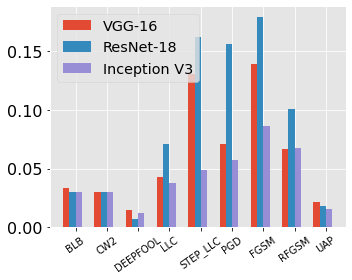

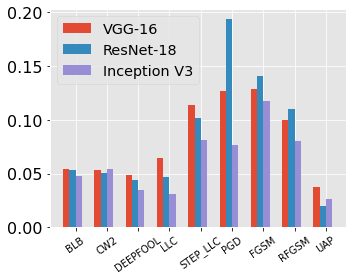

In [21]:
for metric in ['female2male_rate', 'male2female_rate']:
    architectures = ['VGG_16', 'ResNet_18', 'Inception_V3']
    attacks = ['BLB', 'CW2', 'DEEPFOOL', 'LLC', 'STEP_LLC', 'PGD', 'FGSM', 'RFGSM', 'UAP']

    arch_data = {'VGG_16':[], 'ResNet_18':[], 'Inception_V3':[]}
    for arch in architectures:
        for attack in attacks:
            point = arch_df[(arch_df[f'is_{attack}']==1) & (arch_df[f'is_{arch}']==1)][metric].mean()
            arch_data[arch].append(point)

    fig, ax = plt.subplots(figsize=(5,4))
    plt.xticks([i for i in range(len(attacks))], attacks, rotation=35, fontsize=10)
    x = np.arange(len(attacks))
    width = 0.2
    ax.bar(x-1.5*width, arch_data['VGG_16'], width, label='VGG-16')
    ax.bar(x-0.5*width,arch_data['ResNet_18'], width, label='ResNet-18')
    ax.bar(x+0.5*width,arch_data['Inception_V3'],width,label='Inception V3')
    plt.tight_layout()
    plt.legend()
    # plt.savefig(f'{save_dir}/cross_architecture_{metric}.eps', format="eps", bbox_inches = 'tight')
        
